<a href="https://colab.research.google.com/github/jing-yu-lim/Understanding-Transformer-Self-Attention-Maps-Visualisation/blob/main/Understanding_Transformer_Self_Attention_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
import torchvision
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

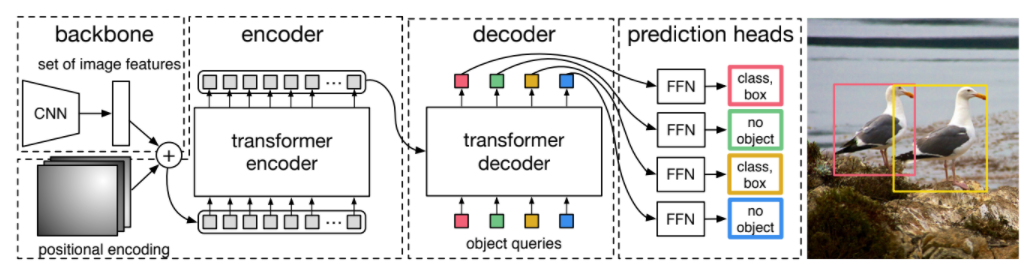

In [3]:
transforms=T.Compose([
                      T.Resize(800),
                      T.ToTensor(),
                      T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [ ]:
model=torch.hub.load('facebookresearch/detr','detr_resnet50',pretrained=True)
model.eval()

In [ ]:
for n, p in model.transformer.named_parameters():
    print(n,p.shape)

In [17]:
url='https://thesmartlocal.com/wp-content/uploads/2015/01/images_easyblog_images_2088_Hock_Lam.jpg'
im=Image.open(requests.get(url,stream=True).raw)
img=transforms(im).unsqueeze(0)

In [18]:
#using hooks to extract attention weights
conv_features,enc_attn_weights=[],[]

hooks=[
        model.backbone[0].register_forward_hook(
            lambda self, input, output: conv_features.append(output)),

        model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output))
]

outputs=model(img)

for hook in hooks:
  hook.remove()
#we dont need the lists anymore
conv_features=conv_features[0] #to get shape of the feature maps i.e. inputs into the transformer encoder  
enc_attn_weights=enc_attn_weights[0]

In [70]:
conv_shape=conv_features['0'].tensors.shape
print(f'shape of conv backbone output: {conv_shape}')
shape=conv_shape[-2:]
sattn_shape1=enc_attn_weights[1][0].reshape(shape+shape)
sattn_shape2=enc_attn_weights[1][0]
print('reshaped self-attention shape 1:',sattn_shape1.shape)
print('reshaped self-attention shape 2:',sattn_shape2.shape)


shape of conv backbone output: torch.Size([1, 2048, 25, 50])
reshaped self-attention shape 1: torch.Size([25, 50, 25, 50])
reshaped self-attention shape 2: torch.Size([1250, 1250])


Try to visualise it; start by selecting a few reference points where will be looking at the attention

928


Text(0.5, 1.0, 'Attn every other pixel pays to the coord (900, 600)\n(H/32 x W/32, H/32 x W/32)[...928]')

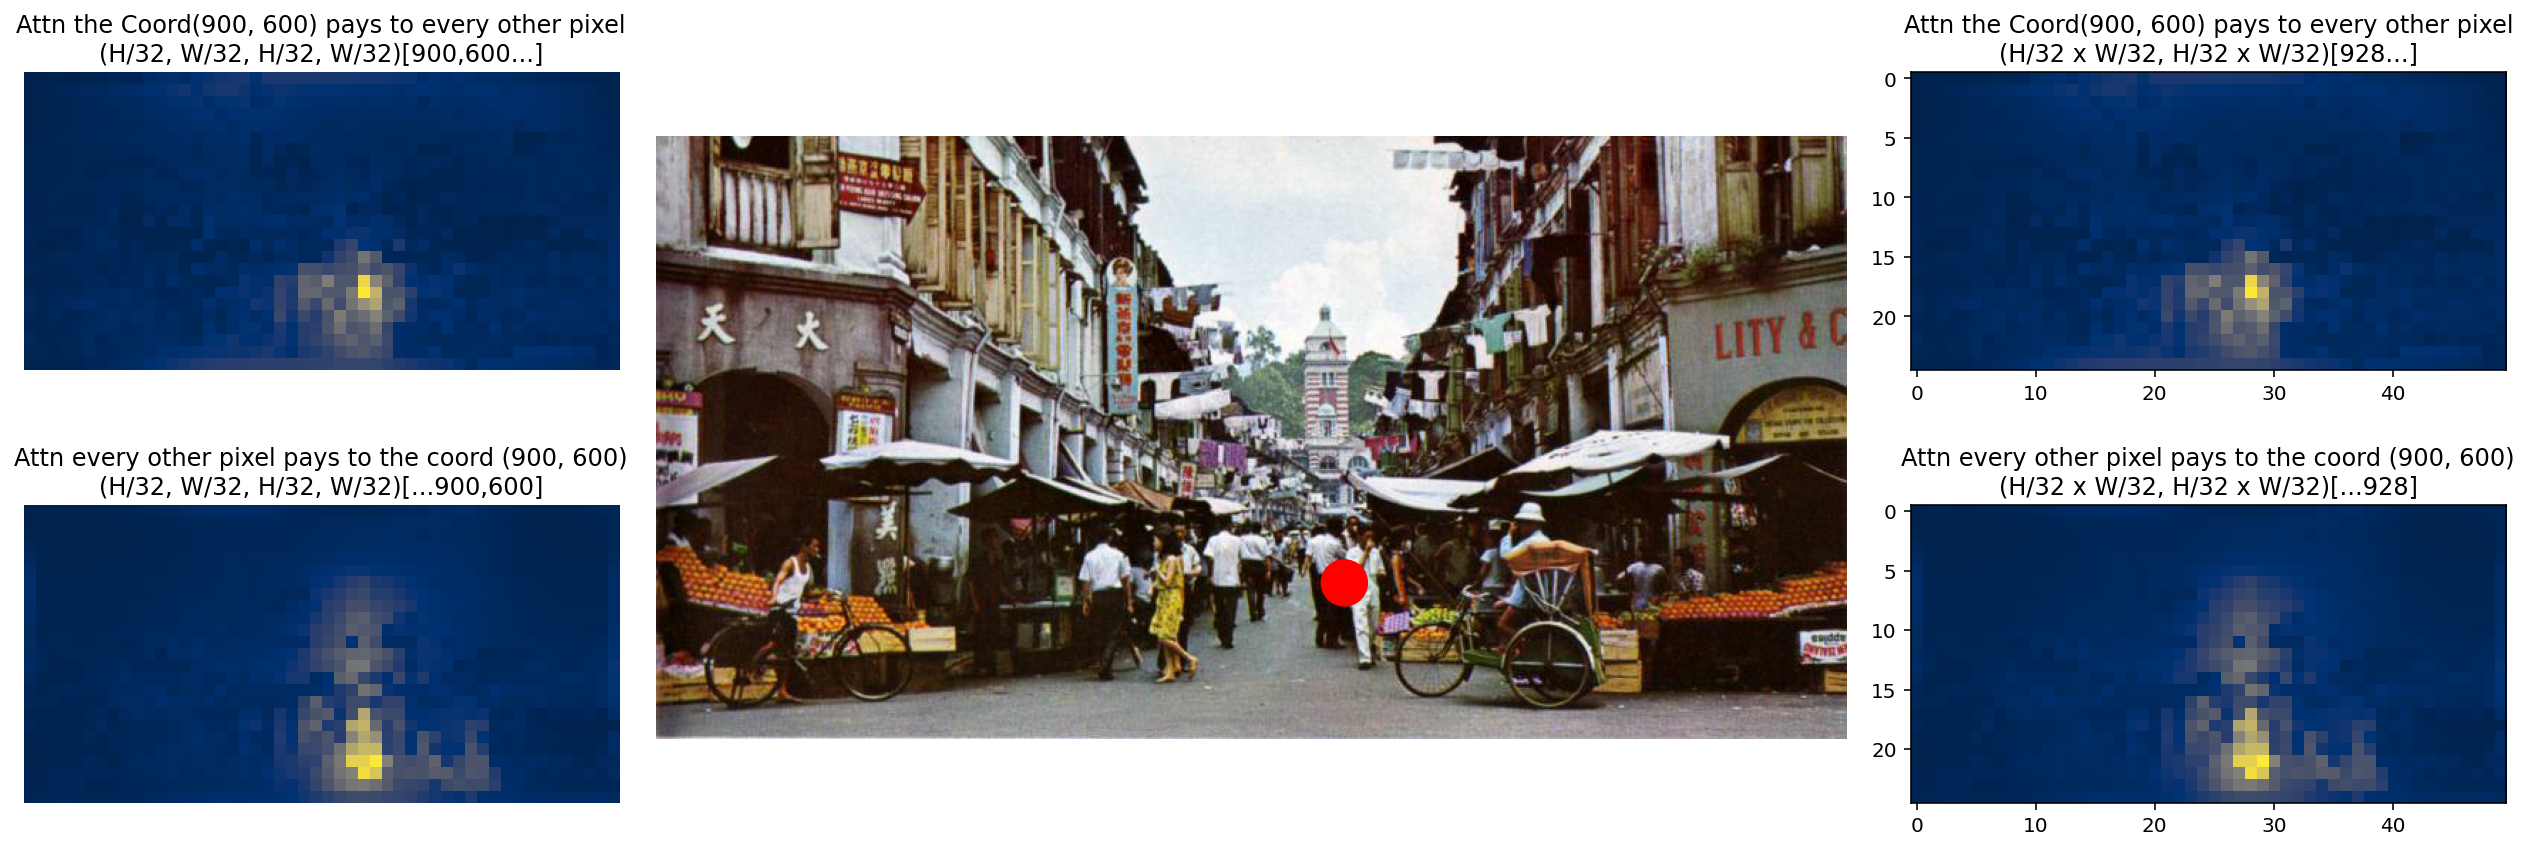

In [80]:
idxs= (900,600)
x=idxs[0]
y=idxs[1]


# downsampling factor for the CNN backbone, from input image to output feature map 
fact = 32

#create the canvas
fig=plt.figure(constrained_layout=True,figsize=(25*0.7,8.5*0.7))
#add one plot per reference point
gs=fig.add_gridspec(2,4)
axs=[
     fig.add_subplot(gs[0,0]),
     fig.add_subplot(gs[1,0]),
     fig.add_subplot(gs[0,-1]),
     fig.add_subplot(gs[1,-1]),
]

# for each one of the reference points, let's plot the self-attention for that point


idx=(x // fact, y // fact) 
axs[0].imshow(sattn_shape1[idx[1],idx[0],...],cmap='cividis',interpolation='nearest')
axs[0].axis('off')
axs[0].set_title(f'Attn the Coord{idxs} pays to every other pixel\n(H/32, W/32, H/32, W/32)[{x},{y}...]')

axs[1].imshow(sattn_shape1[...,idx[1],idx[0]],cmap='cividis',interpolation='nearest')
axs[1].axis('off')
axs[1].set_title(f'Attn every other pixel pays to the coord {idxs}\n(H/32, W/32, H/32, W/32)[...{x},{y}]')

# and now let's add the central image, with the reference points as red circles
fcenter_ax=fig.add_subplot(gs[:,1:-1])# choose which gridspecs to use!
fcenter_ax.imshow(im)

x=idxs[0]
y=idxs[1]
scale = im.height / img.shape[-2]
x=((x // fact) + 0.5) * fact
y=((y // fact) + 0.5) *fact
fcenter_ax.add_patch(plt.Circle((x*scale,y*scale),fact//2,color='r'))
fcenter_ax.axis('off')

#Convert t

pixel_num=idx[1]*conv_shape[-1]+idx[0]

print(pixel_num)

map_1=sattn_shape2[pixel_num,...].reshape(shape)
axs[2].imshow(map_1,cmap='cividis',interpolation='nearest')
axs[2].set_title(f'Attn the Coord{idxs} pays to every other pixel\n(H/32 x W/32, H/32 x W/32)[{pixel_num}...]')

map_2=sattn_shape2[...,pixel_num].reshape(shape)
axs[3].imshow(map_2,cmap='cividis',interpolation='nearest')
axs[3].set_title(f'Attn every other pixel pays to the coord {idxs}\n(H/32 x W/32, H/32 x W/32)[...{pixel_num}]')